#                                      Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

### Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import lightgbm as lgbm
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, mean_squared_error as mse

### Пути к директориям и файлам

In [175]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [176]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [177]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [178]:
df_train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00000,NaN,0.00000,11.00000,26.30000,685960.00000,1.00000,NaN,1.00000,debt consolidation,Short Term,99999999.00000,47386.00000,7914.00000,749.00000,0
1,Own Home,1025487.00000,10+ years,0.00000,15.00000,15.30000,1181730.00000,0.00000,NaN,0.00000,debt consolidation,Long Term,264968.00000,394972.00000,18373.00000,737.00000,1
2,Home Mortgage,751412.00000,8 years,0.00000,11.00000,35.00000,1182434.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,99999999.00000,308389.00000,13651.00000,742.00000,0
3,Own Home,805068.00000,6 years,0.00000,8.00000,22.50000,147400.00000,1.00000,NaN,1.00000,debt consolidation,Short Term,121396.00000,95855.00000,11338.00000,694.00000,0
4,Rent,776264.00000,8 years,0.00000,13.00000,13.60000,385836.00000,1.00000,NaN,0.00000,debt consolidation,Short Term,125840.00000,93309.00000,7180.00000,719.00000,0


In [179]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Оценка баланска классов

In [180]:
df_train['Credit Default'].value_counts(normalize=True)

0   0.71827
1   0.28173
Name: Credit Default, dtype: float64

Баланс достаточно сильно смещен в пользу 0 класса

In [181]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00000,7500.00000,7500.00000,7500.00000,7500.00000,7500.00000,3419.00000,7486.00000,7500.00000,7500.00000,7500.00000,5943.00000,7500.00000
mean,1366391.72017,0.03013,11.13093,18.31747,945153.72747,0.17000,34.69260,0.11715,11873177.44507,289833.23520,18314.45413,1151.08750,0.28173
std,845339.19963,0.27160,4.90892,7.04195,16026216.67085,0.49860,21.68881,0.34719,31926122.97473,317871.38238,11926.76467,1604.45142,0.44987
min,164597.00000,0.00000,2.00000,4.00000,0.00000,0.00000,0.00000,0.00000,11242.00000,0.00000,0.00000,585.00000,0.00000
25%,844341.00000,0.00000,8.00000,13.50000,279229.50000,0.00000,16.00000,0.00000,180169.00000,114256.50000,10067.50000,711.00000,0.00000
50%,1168386.00000,0.00000,10.00000,17.00000,478159.00000,0.00000,32.00000,0.00000,309573.00000,209323.00000,16076.50000,731.00000,0.00000
75%,1640137.00000,0.00000,14.00000,21.80000,793501.50000,0.00000,50.00000,0.00000,519882.00000,360406.25000,23818.00000,743.00000,1.00000
max,10149344.00000,7.00000,43.00000,57.70000,1304726170.00000,7.00000,118.00000,4.00000,99999999.00000,6506797.00000,136679.00000,7510.00000,1.00000


- Maximum Open Credit проверить на выбросы
- Current Loan Amount подозрительное макс значение
- Current Credit Balance - посмотреть выброс или нет.
- Credit score -  посмотреть частоту значений, возможно верхняя граница это просто ошибка лишей цифры.
- Current Credit Balance, Monthly Debt - посмотреть 0 значения.

### Выбросы

#### Maximum Open Credit

<AxesSubplot:xlabel='Maximum Open Credit'>

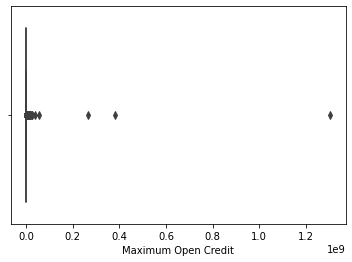

In [182]:
sns.boxplot(df_train['Maximum Open Credit'])

Значения совсем фантастические. Заменим все что выше q=0.995 медианой.

In [183]:
max_open_credit = np.quantile(df_train['Maximum Open Credit'], q=0.995)
max_open_credit_median = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Maximum Open Credit'] > max_open_credit, 'Maximum Open Credit'] = max_open_credit_median

<AxesSubplot:xlabel='Maximum Open Credit', ylabel='Density'>

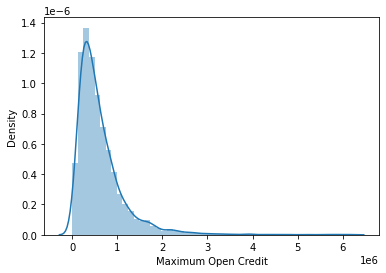

In [184]:
sns.distplot(df_train['Maximum Open Credit'])

<AxesSubplot:xlabel='Maximum Open Credit'>

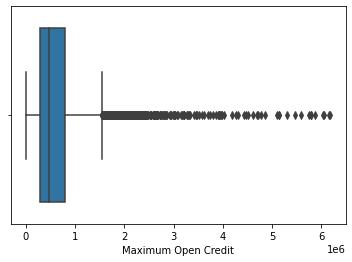

In [185]:
sns.boxplot(df_train['Maximum Open Credit'])

In [186]:
df_train['Maximum Open Credit'].describe()

count      7500.00000
mean     624807.57680
std      566664.65146
min           0.00000
25%      279229.50000
50%      478153.50000
75%      786098.50000
max     6183782.00000
Name: Maximum Open Credit, dtype: float64

#### Current Loan Amount

In [187]:
df_train['Current Loan Amount'].value_counts()

99999999.00000    870
218064.00000        6
89298.00000         6
216106.00000        5
265826.00000        5
                 ... 
104324.00000        1
201080.00000        1
427812.00000        1
665544.00000        1
191136.00000        1
Name: Current Loan Amount, Length: 5386, dtype: int64

<AxesSubplot:>

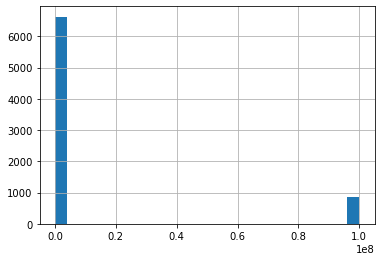

In [188]:
df_train['Current Loan Amount'].hist(bins=25)

Я так подозреваю значение 99999999 это правое скопление, явно не являющееся нормальным. Дальнейшее изучение этого значения показало, что выброс является своего рода меткой, т.к. все наблюдения с таким значением относятся к 0 классу.

In [189]:
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Credit Default'].value_counts()

0    870
Name: Credit Default, dtype: int64

#### Current Credit Balance

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

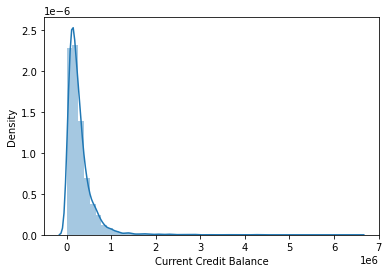

In [190]:
sns.distplot(df_train['Current Credit Balance'])

Верхняя граница достаточно большая, но и не чтоб супербольшая. Хотя не известно, включается ли тут деньги лежащие на дебетовом счете в общую сумму. По идее можно было посмотреть  людей у которых кредитный счет выше чем сумма кредита. По идее, если на счету денег больше, чем сумма кредита, то что мешает человеку не пропустить выплату??

In [191]:
df_train.loc[df_train['Current Credit Balance'] > df_train['Current Loan Amount'], 'Credit Default'].value_counts(normalize=True)

0   0.69661
1   0.30339
Name: Credit Default, dtype: float64

Практически не отличается от изначального распределения классов. Теория не подтвердилась.

#### Monthly Debt

Теперь нужно посмотреть нули.

<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

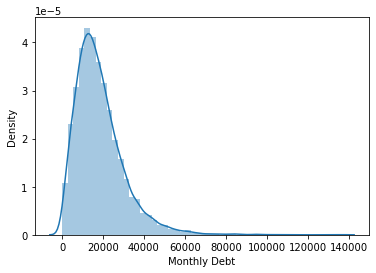

In [192]:
sns.distplot(df_train['Monthly Debt'])

In [193]:
df_train.loc[df_train['Monthly Debt'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.00000,10+ years,0.00000,2.00000,16.50000,0.00000,0.00000,66.00000,0.00000,home improvements,Short Term,75350.00000,0.00000,0.00000,704.00000,0
1643,Rent,NaN,9 years,0.00000,3.00000,10.00000,0.00000,0.00000,NaN,0.00000,other,Short Term,332156.00000,0.00000,0.00000,NaN,1
3219,Home Mortgage,NaN,10+ years,0.00000,3.00000,18.50000,0.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,79200.00000,0.00000,0.00000,NaN,0
3496,Rent,233567.00000,1 year,0.00000,7.00000,11.70000,0.00000,0.00000,0.00000,NaN,educational expenses,Short Term,210166.00000,0.00000,0.00000,746.00000,0
4165,Rent,1254513.00000,10+ years,0.00000,6.00000,23.40000,0.00000,0.00000,60.00000,0.00000,take a trip,Short Term,99999999.00000,0.00000,0.00000,748.00000,0
7124,Rent,NaN,1 year,0.00000,4.00000,11.00000,0.00000,0.00000,50.00000,0.00000,debt consolidation,Short Term,134024.00000,0.00000,0.00000,NaN,0


Вообще ерунда, кредитная история много лет, максимальный кредит 0, при этом просрочка кредита у некторых имеется. В тоже время имеется взятый кредит, но выплата 0 в месяц. 

Вообще нижняя планка меня удивляет, куча наблюдений, в которых короткое время кредита, при этом ежемесячный платеж  0.1% - 0.5%  от суммы. С другой стороны, конечно, если мне, грубо говоря, надо отдавать 100руб в месяц за кредит, то вероятность, что я отдам очень высока.

#### Credit Score

<AxesSubplot:>

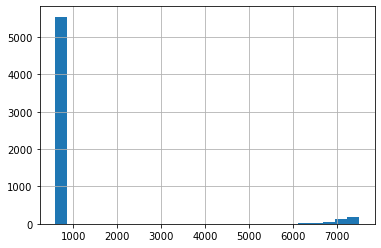

In [194]:
df_train["Credit Score"].hist(bins=25)

In [195]:
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

В признаке имеются наблюдения в которых значение умножено на 10, и все наблюдения с такими признакам относятся к 1 классу. Вероятнее всего это специально помеченные данные.

### Пропуски

#### Annual Income 

Подумаем, чем можно заполнить пропуски. Значений довольно много, просто какойто средней или медианой заполнять получится перекос. Либо делаем так и создаем признак, и отмечаем, что было пропущено значение, либо выбрать метод заполнения по хитрее. 

<AxesSubplot:xlabel='Annual Income', ylabel='Density'>

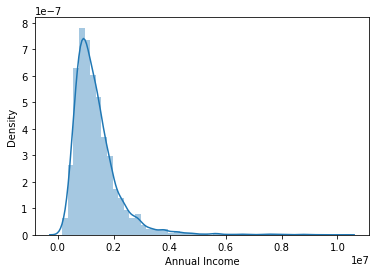

In [196]:
sns.distplot(df_train["Annual Income"])

Можно посмотреть, как разделяется среднее по стажу работы.

In [197]:
df_train.groupby(by="Years in current job")["Annual Income"].mean()

Years in current job
1 year      1268811.12060
10+ years   1510598.04572
2 years     1324516.68157
3 years     1396487.28163
4 years     1371733.44865
5 years     1330785.57323
6 years     1311730.11966
7 years     1341805.04545
8 years     1390800.27143
9 years     1444429.35979
< 1 year    1204723.05369
Name: Annual Income, dtype: float64

Не особо сильно, но явно виден рост зп со стажем, что стоило ожидать.
В теории, ежемесячный платеж должен быть завязан на ЗП, можно посмотреть по матрице корреляции данный признак.

In [198]:
corr_matrix = df_train.corr()
corr_matrix["Annual Income"]

Annual Income                   1.00000
Tax Liens                       0.06624
Number of Open Accounts         0.18852
Years of Credit History         0.18653
Maximum Open Credit             0.32666
Number of Credit Problems      -0.01541
Months since last delinquent   -0.10179
Bankruptcies                   -0.06688
Current Loan Amount             0.03208
Current Credit Balance          0.38648
Monthly Debt                    0.58482
Credit Score                   -0.03783
Credit Default                 -0.10138
Name: Annual Income, dtype: float64

Я был прав, самая большая корреляция с Ежемесячным платежом. Можно например узнать соотношение средней ЗП по всем к средней Ежемесячных платежей, далее предсказывать пропущенные ЗП домножая на коэффициент.

In [199]:
annual_incom_coef = df_train["Annual Income"].mean() / df_train['Monthly Debt'].mean()

In [200]:
df_train.loc[df_train["Annual Income"].isnull(), "Annual Income"] = df_train["Monthly Debt"] * annual_incom_coef

<AxesSubplot:xlabel='Annual Income', ylabel='Density'>

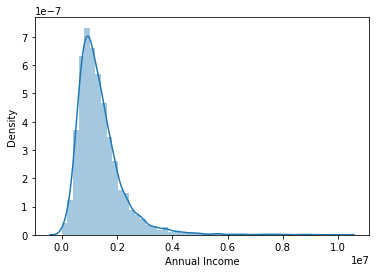

In [201]:
sns.distplot(df_train["Annual Income"])

Распределение значений более честное, на мой взгляд.

#### Years in current job

Ну тут значений не много, заменим модой

In [202]:
current_job_mode = df_train['Years in current job'].mode()[0]

In [203]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = current_job_mode

#### Months since last delinquent

Признак не простой, вероятнее всего пропущенные значения, это клиенты которые никогда не просрачивали кредит, и важно это правильно объяснить модели т.к. это весомый довод выдать кредит. Мы не можем написать 0, т.к. это значит, что просрока была в это м месяце. Нужно большое число. Можно взять максимальное число из признака и также создать доп признак.

In [204]:
df_train.loc[df_train['Months since last delinquent'].notnull()]['Credit Default'].value_counts(normalize=True)

0   0.71249
1   0.28751
Name: Credit Default, dtype: float64

In [205]:
df_train.loc[df_train['Months since last delinquent'].isnull()]['Credit Default'].value_counts(normalize=True)

0   0.72311
1   0.27689
Name: Credit Default, dtype: float64

Хотя даже такие ребята, которые не имели просрочки, имеют не сильное различие в целевом признаке.

Попробуем следующий шаг: Предположим, что это всетаки люди, которые не просрачивали кредит. По этому заполним пропущенные значения года кредитной истории*12, и посмотрим,как это повлияет на качество.

In [206]:
df_train['Delinquent'] = 1
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Delinquent'] = 0

df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Years of Credit History'] * 12

<AxesSubplot:>

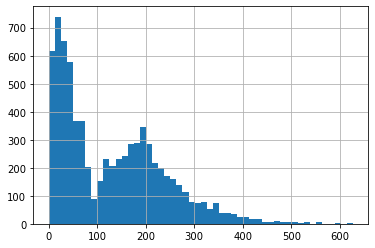

In [207]:
df_train['Months since last delinquent'].hist(bins=50)

Рисковая практика, получился целый доп кластер. Попробуем пока оставить. С одной стороны информация то полезная, когда был послений прокол.. И доп признак, Были просрочки \ Не было. 


#### Bankruptcies

Тут пропусков не много, можно заменить медианой.

In [208]:
bankruptcies_median = df_train['Bankruptcies'].median()

In [209]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = bankruptcies_median

#### Credit Score

In [210]:
corr_matrix = df_train.corr()
corr_matrix["Credit Score"]

Annual Income                  -0.03783
Tax Liens                       0.01058
Number of Open Accounts         0.01610
Years of Credit History        -0.01568
Maximum Open Credit            -0.02496
Number of Credit Problems      -0.01847
Months since last delinquent   -0.01281
Bankruptcies                   -0.02789
Current Loan Amount            -0.10855
Current Credit Balance         -0.00616
Monthly Debt                    0.00023
Credit Score                    1.00000
Credit Default                  0.44205
Delinquent                     -0.00108
Name: Credit Score, dtype: float64

Для более точного предсказания хорошо бы знать формулу расчета рейтинга, т.к. корреляции слабые, для нормальних предсказаний, заполним медианой.

In [211]:
credit_score_median = df_train['Credit Score'].median()

In [212]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = credit_score_median

### Обработка не числовых значений.

#### Home Ownership

In [213]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [214]:
df_train.groupby(by='Home Ownership')['Credit Default'].mean()

Home Ownership
Have Mortgage   0.16667
Home Mortgage   0.25186
Own Home        0.29675
Rent            0.31305
Name: Credit Default, dtype: float64

Чем больше среднее, тем больше наблюдений 1 класса. Интересно, что у тех, кто арендует дома\квартиру, не погашен кредит чаще всего. Можно заменить тип домовладения, соответствующей статистикой.

In [215]:
home_ownership_credit_default_stat = df_train.groupby(by='Home Ownership')['Credit Default'].mean().to_dict()

In [216]:
home_ownership_credit_default_stat

{'Have Mortgage': 0.16666666666666666,
 'Home Mortgage': 0.2518559252130877,
 'Own Home': 0.29675425038639874,
 'Rent': 0.3130461922596754}

In [217]:
df_train.replace({"Home Ownership": home_ownership_credit_default_stat}, inplace=True )

#### Years in current job

In [218]:
df_train['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Тут можно просто, перевести в непрерывный тип, т.к. по сути признак таким и является. 

In [219]:
years_in_current_job_dict = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}

In [220]:
df_train.replace({'Years in current job': years_in_current_job_dict}, inplace=True)

#### Purpose

In [221]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Много значений. Можно перевести их в доли популярности. 

In [222]:
purpose_stat = df_train['Purpose'].value_counts(normalize=True).to_dict()

In [223]:
df_train.replace({'Purpose': purpose_stat}, inplace=True)

####  Term

In [224]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Просто переведем в бинарный признак.

In [225]:
df_train['Term'] = (df_train['Term'] == 'Short Term').astype(int)

### Доп фичи

1) Попробуем посмотреть на сколько сильно влияет на классы коэффициент использования кредита.

In [226]:
df_train['Use coef'] = df_train['Current Credit Balance'] / df_train['Current Loan Amount']

Возьмем для анализа только не помеченные данные.

In [227]:
df_1 = df_train.loc[df_train['Current Loan Amount']!= 99999999]

In [228]:
df_1.groupby(by='Term')['Use coef'].mean()

Term
0   0.81803
1   1.28136
Name: Use coef, dtype: float64

Люди с долгосрочным кредитом тратят примерно на 60% меньше денег с кредитного счета.

<AxesSubplot:xlabel='Use coef', ylabel='Density'>

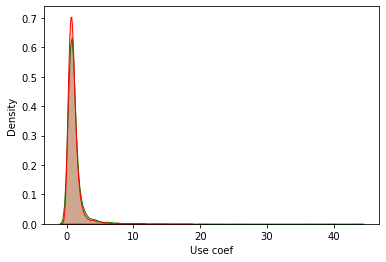

In [229]:
incom_spread = df_1[['Use coef', 'Credit Default']]
incom_1 = incom_spread.loc[incom_spread['Credit Default'] == 1, 'Use coef']
incom_0 = incom_spread.loc[incom_spread['Credit Default'] == 0, 'Use coef']
sns.kdeplot(incom_0, shade=True,  color='g')
sns.kdeplot(incom_1, shade=True,  color='r')


In [230]:
mannwhitneyu(incom_0, incom_1)

MannwhitneyuResult(statistic=4522653.0, pvalue=0.0002948150703523884)

pvalue достаточно мало, чтобы сказать, что признак статважен.

2) Получим предположительную длительность кредита

In [231]:
df_train['Time coef'] = df_train['Current Loan Amount'] / (df_train['Monthly Debt']+1)

Возьмем для анализа только не помеченные данные.

In [232]:
df_1 = df_train.loc[df_train['Current Loan Amount']!= 99999999]

<AxesSubplot:xlabel='Time coef', ylabel='Density'>

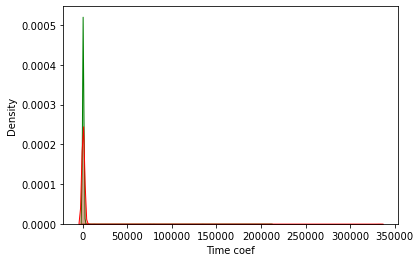

In [233]:
incom_spread = df_1[['Time coef', 'Credit Default']]
incom_1 = incom_spread.loc[incom_spread['Credit Default'] == 1, 'Time coef']
incom_0 = incom_spread.loc[incom_spread['Credit Default'] == 0, 'Time coef']
sns.kdeplot(incom_0, shade=True,  color='g')
sns.kdeplot(incom_1, shade=True,  color='r')

In [234]:
mannwhitneyu(incom_0, incom_1)

MannwhitneyuResult(statistic=4536514.0, pvalue=0.0005862703071256868)

pvalue достаточно мало, чтобы сказать, что признак статважен.

## Обучим модель

Заново загрузим трейн дата сет, разобьем на трейн и валид, и еще раз проделаем все наши манипуляции.

In [304]:
train = pd.read_csv(TRAIN_DATASET_PATH)

In [305]:
valid = train.iloc[5000:]
train = train.iloc[:5000]



Заново переопределим переменные

#### Переменные

In [306]:

credit_balance_median = train['Current Credit Balance'].median()
annual_incom_coef = train["Annual Income"].mean() / train['Monthly Debt'].mean()
current_job_mode = train['Years in current job'].mode()[0]
credit_score_median = train['Credit Score'].median()
home_ownership_credit_default_stat = train.groupby(by='Home Ownership')['Credit Default'].mean().to_dict()
years_in_current_job_dict = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}
purpose_stat = train['Purpose'].value_counts(normalize=True).to_dict()
max_delinquent = train['Months since last delinquent'].max()


#### Функция предобработки данных

In [307]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [308]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [309]:
def prep_data(df):
    

    df.loc[df["Annual Income"].isnull(), "Annual Income"] = df["Monthly Debt"] * annual_incom_coef
    
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = current_job_mode
    
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df['Years of Credit History'] * 12

    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = credit_score_median
    

    #Фичи

    
    df.replace({"Home Ownership": home_ownership_credit_default_stat}, inplace=True )
        
    df.replace({'Years in current job': years_in_current_job_dict}, inplace=True)
    
    df.replace({'Purpose': purpose_stat}, inplace=True)
    
    df['Term'] = (df['Term'] == 'Short Term').astype(int)
    
    df['Use coef'] = (df['Current Credit Balance'] / df['Current Loan Amount']) 
    
    df['Acc coef'] =  df['Number of Open Accounts'] / df['Years of Credit History']
    
    df['Time coef'] = df['Current Loan Amount'] / (df['Monthly Debt']+1)

    df['Time2 coef'] =  ((df['Years of Credit History']*12) - df['Months since last delinquent']) / (df['Number of Credit Problems']+1)
    
    df['Acc coef2'] = df['Current Credit Balance'] / df['Number of Open Accounts']
    
    return df

In [310]:
train = prep_data(train)
valid = prep_data(valid)

In [311]:
train = balance_df_by_target(train, "Credit Default")

In [312]:
X_train, y_train = train.drop("Credit Default", axis = 1), train["Credit Default"]

X_valid, y_valid = valid.drop("Credit Default", axis = 1), valid["Credit Default"]


In [313]:
model_lgbm = lgbm.LGBMClassifier(class_weight = 'balanced', min_child_samples = 8, learning_rate =  0.1 , n_estimators = 1600, max_depth = 1, random_state = 42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      3617
           1       0.67      0.74      0.71      2766

    accuracy                           0.73      6383
   macro avg       0.73      0.73      0.73      6383
weighted avg       0.74      0.73      0.73      6383

TEST

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      1770
           1       0.48      0.68      0.57       730

    accuracy                           0.69      2500
   macro avg       0.66      0.69      0.66      2500
weighted avg       0.74      0.69      0.70      2500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1233  537
1                231  499


In [314]:
f1_score(y_valid, y_test_pred)

0.565118912797282

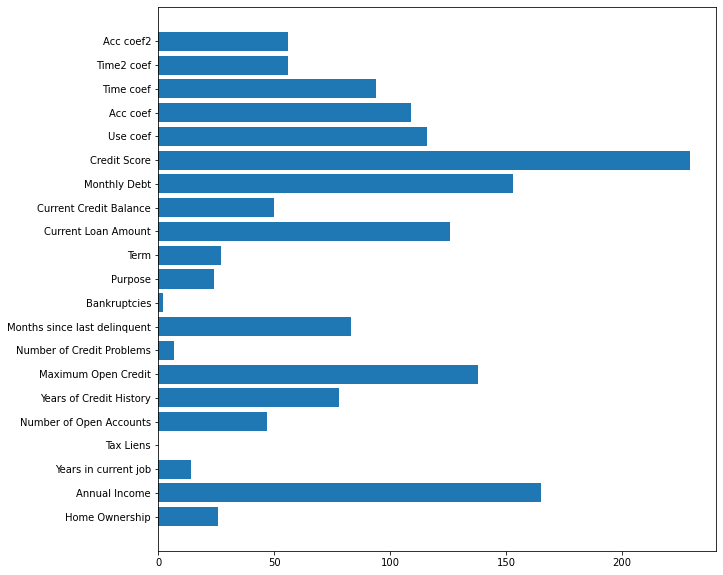

In [315]:
f_i = model_lgbm.feature_importances_
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

### Заново обучим модель на всех трейн данных, и предскажем тестовую выборку. 

In [316]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [317]:
credit_balance_median = train['Current Credit Balance'].median()
annual_incom_coef = train["Annual Income"].mean() / train['Monthly Debt'].mean()
current_job_mode = train['Years in current job'].mode()[0]
credit_score_median = train['Credit Score'].median()
home_ownership_credit_default_stat = train.groupby(by='Home Ownership')['Credit Default'].mean().to_dict()
years_in_current_job_dict = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}
purpose_stat = train['Purpose'].value_counts(normalize=True).to_dict()
max_delinquent = train['Months since last delinquent'].max()

In [318]:
train = prep_data(train)
test = prep_data(test)

In [319]:
train = balance_df_by_target(train, "Credit Default")

In [320]:
X_train, y_train = train.drop("Credit Default", axis = 1), train["Credit Default"]

X_test = test

In [321]:
model_lgbm = lgbm.LGBMClassifier(class_weight = 'balanced', min_child_samples = 5, learning_rate =  0.1 , n_estimators = 1600, max_depth = 1, random_state = 42)
model_lgbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', max_depth=1, min_child_samples=5,
               n_estimators=1600, random_state=42)

In [322]:
y_test_pred = model_lgbm.predict(X_test)

In [323]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['Credit Default'])

In [324]:
y_test_pred.to_csv('IKurkov_predictions.csv', index=False)

### Заключение

Что я почерпнул из этой работы:
- Я убедился, что алгоритмы на основе деревьев очень хорошо вычисляют меченные данные. Так например наш алгоритм безошибочно определил меченные данные в признаках Current Loan Amount и Credit score. 
- Это вторая моя модель за все время, и второй раз я вижу, что какие либо обработки выбросов приводят к ухудшению модели на основе деревьев. Может это учебные данные такие, или я все не правильно делаю, но это то, что я увидел ( Хотелось бы получить комментарии преподователя на этот счет).
- Надо не забывать следить за переобучением. По началу я не обратил на это внимание, но увидев f1 на тестовых данных 98-99% я начал играться с глубиной деревьев и количеством\скоростью обучения. В итоге сравняв точность тестовой и валидационных выборок удалось повысить и  f1 валидационной выборки на несколько процентов. 
- При использовании алгоритма градиентного бустинга, почемуто удаление признаков с практически 0 весом всеравно ведет к ухудшению точности. Однако  LGBMClassifier хорошо отсекает маловажные признаки без потери качества. (  Хотелось бы получить комментарии преподователя на этот счет, т.к. на предыдущем курсе с регрессией учили удалять маловажные признаки)
- Также использование параметра "class_weight='balanced'" позволило нам найти оптимальный порог класса 1. При этом recall 1 класса получился на много больше, чем без этого параметра, что для задачи скоринга достаточно полезный факт.